In [1]:
import bilby
import os
import glob
import numpy as np
from scipy import interpolate
import utilizes_plot
import corner.corner
import scienceplots
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

# Function of obtaining the peak value from mass function based on posterior

In [2]:
def HDI(xx,yy,ci):
    f0 = interpolate.interp1d(xx, yy, bounds_error=False, fill_value=0)
    samp_max=np.max(xx)
    samp_min=np.min(xx)
    def norm_p(x):
        
        a=np.linspace(samp_min,samp_max,1000)
        return f0(x)/np.trapz(f0(a),a)
    dx=np.linspace(samp_min,samp_max,1000)
    dy=norm_p(dx)
    Tstep=np.diff(dx)[0]
    posterior_m1= dy
    sort_p = np.sort(posterior_m1)[::-1]
    sort_parg = np.argsort(posterior_m1)[::-1]
# compute accumulate probability, save critical index
    cdf, confidence_level = 0, ci
    for k in range(0, len(sort_p)):
        if cdf <= confidence_level:
            cdf += sort_p[k]*Tstep
        else:
            index = k
            break
    # find the boundary, i.e. 1 ci%_low 2 peak 3 ci%_high
    return np.min(dx[sort_parg[:index]]),  dx[sort_parg[0]], np.max(dx[sort_parg[:index]])

# finding the posterior of different data set

In [3]:
parent_dir_path=os.path.abspath( os.path.join(os.getcwd(),'..')) 
main_direct=parent_dir_path+'/NSmassData/posteriors/'
mrms_data_label=['ns_obs','ana_corrected_mrms_87','phe_corrected_mrms_87','ana_corrected_mr_53','phe_corrected_mr_53','mr_obs_53','ms_34','ana_radio']
############# j=   0                1                       2                      3                       4                  5      6        7
sub_model_name_list=['turn_on_pow','turn_on_pow_fix','turn_on_pow_G','pow', '2G','turn_on_pow_G_fixed_max','G','2G_fixed_max', 'sst', 'G_fixed_max', '2G_fixed_min','2G_fixed_max_min','logu','3G_fixed_max_min','lognorm','gamma', 'U','G_fixed_max_min']
############ i=           0(4)       1(3)                2(7)         3(3)   4(7)            5(6)          6(4)       7(6)     8(4)        9(3)            10(6)              11(5)     12(2)      13(8)           14(2)    15(2)  16(2)      17(2)   
data_name_labes=[r'$\rm{OBS}$',r'$\rm{ANA}$',r'$\rm{PHE}$',r'$\rm{ANA_{m_r}}$',r'$\rm{PHE_{m_r}}$',r'$\rm{m_r}$',r'$\rm{m_s}$',r'$\rm{ANA_{radio}}$']
model_name_label=[r'$\rm{TOP}$',r'$\rm{TOP_{min}}$',r'$\rm{TOPG}$',r'$\rm{POW}$',r'$\rm{2G^{max}_{min}}$',r'$\rm{TOPG_{min}}$',r'$\rm{G^{max}_{min}}$',r'$\rm{2G_{min}}$',r'$\rm{SST}$',r'$\rm{G_{min}}$',r'$\rm{2G_{max}}$',r'$\rm{2G}$',r'$\rm{LogU}$',r'$\rm{3G}$',r'$\rm{LogN}$',r'$\rm{Gamma}$',r'$\rm{U}$',r'$\rm{G}$']
###########

In [4]:
rec_post_dic= glob.glob( main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[5],sub_model_name_list[0])  )
slow_post_dic=glob.glob( main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[6],sub_model_name_list[0])  )
anamr_post_dic=glob.glob( main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[3],sub_model_name_list[0])  )

# computing the peak value of top mass model

In [5]:
mii=np.linspace(0.7,3,400)
post_files_names=[rec_post_dic,slow_post_dic,anamr_post_dic]
rec_slow_anamr_post=list()
for i in range(3):
    re=bilby.result.read_in_result( post_files_names[i][0] )
    temp_post=((re.posterior).iloc[:,0:-2]).values
    rec_slow_anamr_post.append(temp_post)
    peak_te=np.zeros(  len(rec_slow_anamr_post[i] ) )
    for k in range(len(rec_slow_anamr_post[i])):
        post_tem=rec_slow_anamr_post[i]
        mass_model=eval('utilizes_plot.hyper_prior_turn_on_pow' )
        model_curve_yi=mass_model(mii,post_tem[k,0],post_tem[k,1],post_tem[k,2],post_tem[k,3])
        peak_te[k]=HDI(mii,model_curve_yi,0.9)[1] 
    rec_slow_anamr_post[i]=np.insert(post_tem,4,peak_te,axis=1)

In [6]:
mr_pos_sam=rec_slow_anamr_post[0]
anamr_pos_sam=rec_slow_anamr_post[2]
ms_pos_sam=rec_slow_anamr_post[1]

In [7]:
data_ms_anamr=list()
data_ms_anamr.append(ms_pos_sam[:,[1,4,2,0]])
data_ms_anamr.append(anamr_pos_sam[:,[1,4,2,0]])

# ploting corner figure [extended figure 6 up]

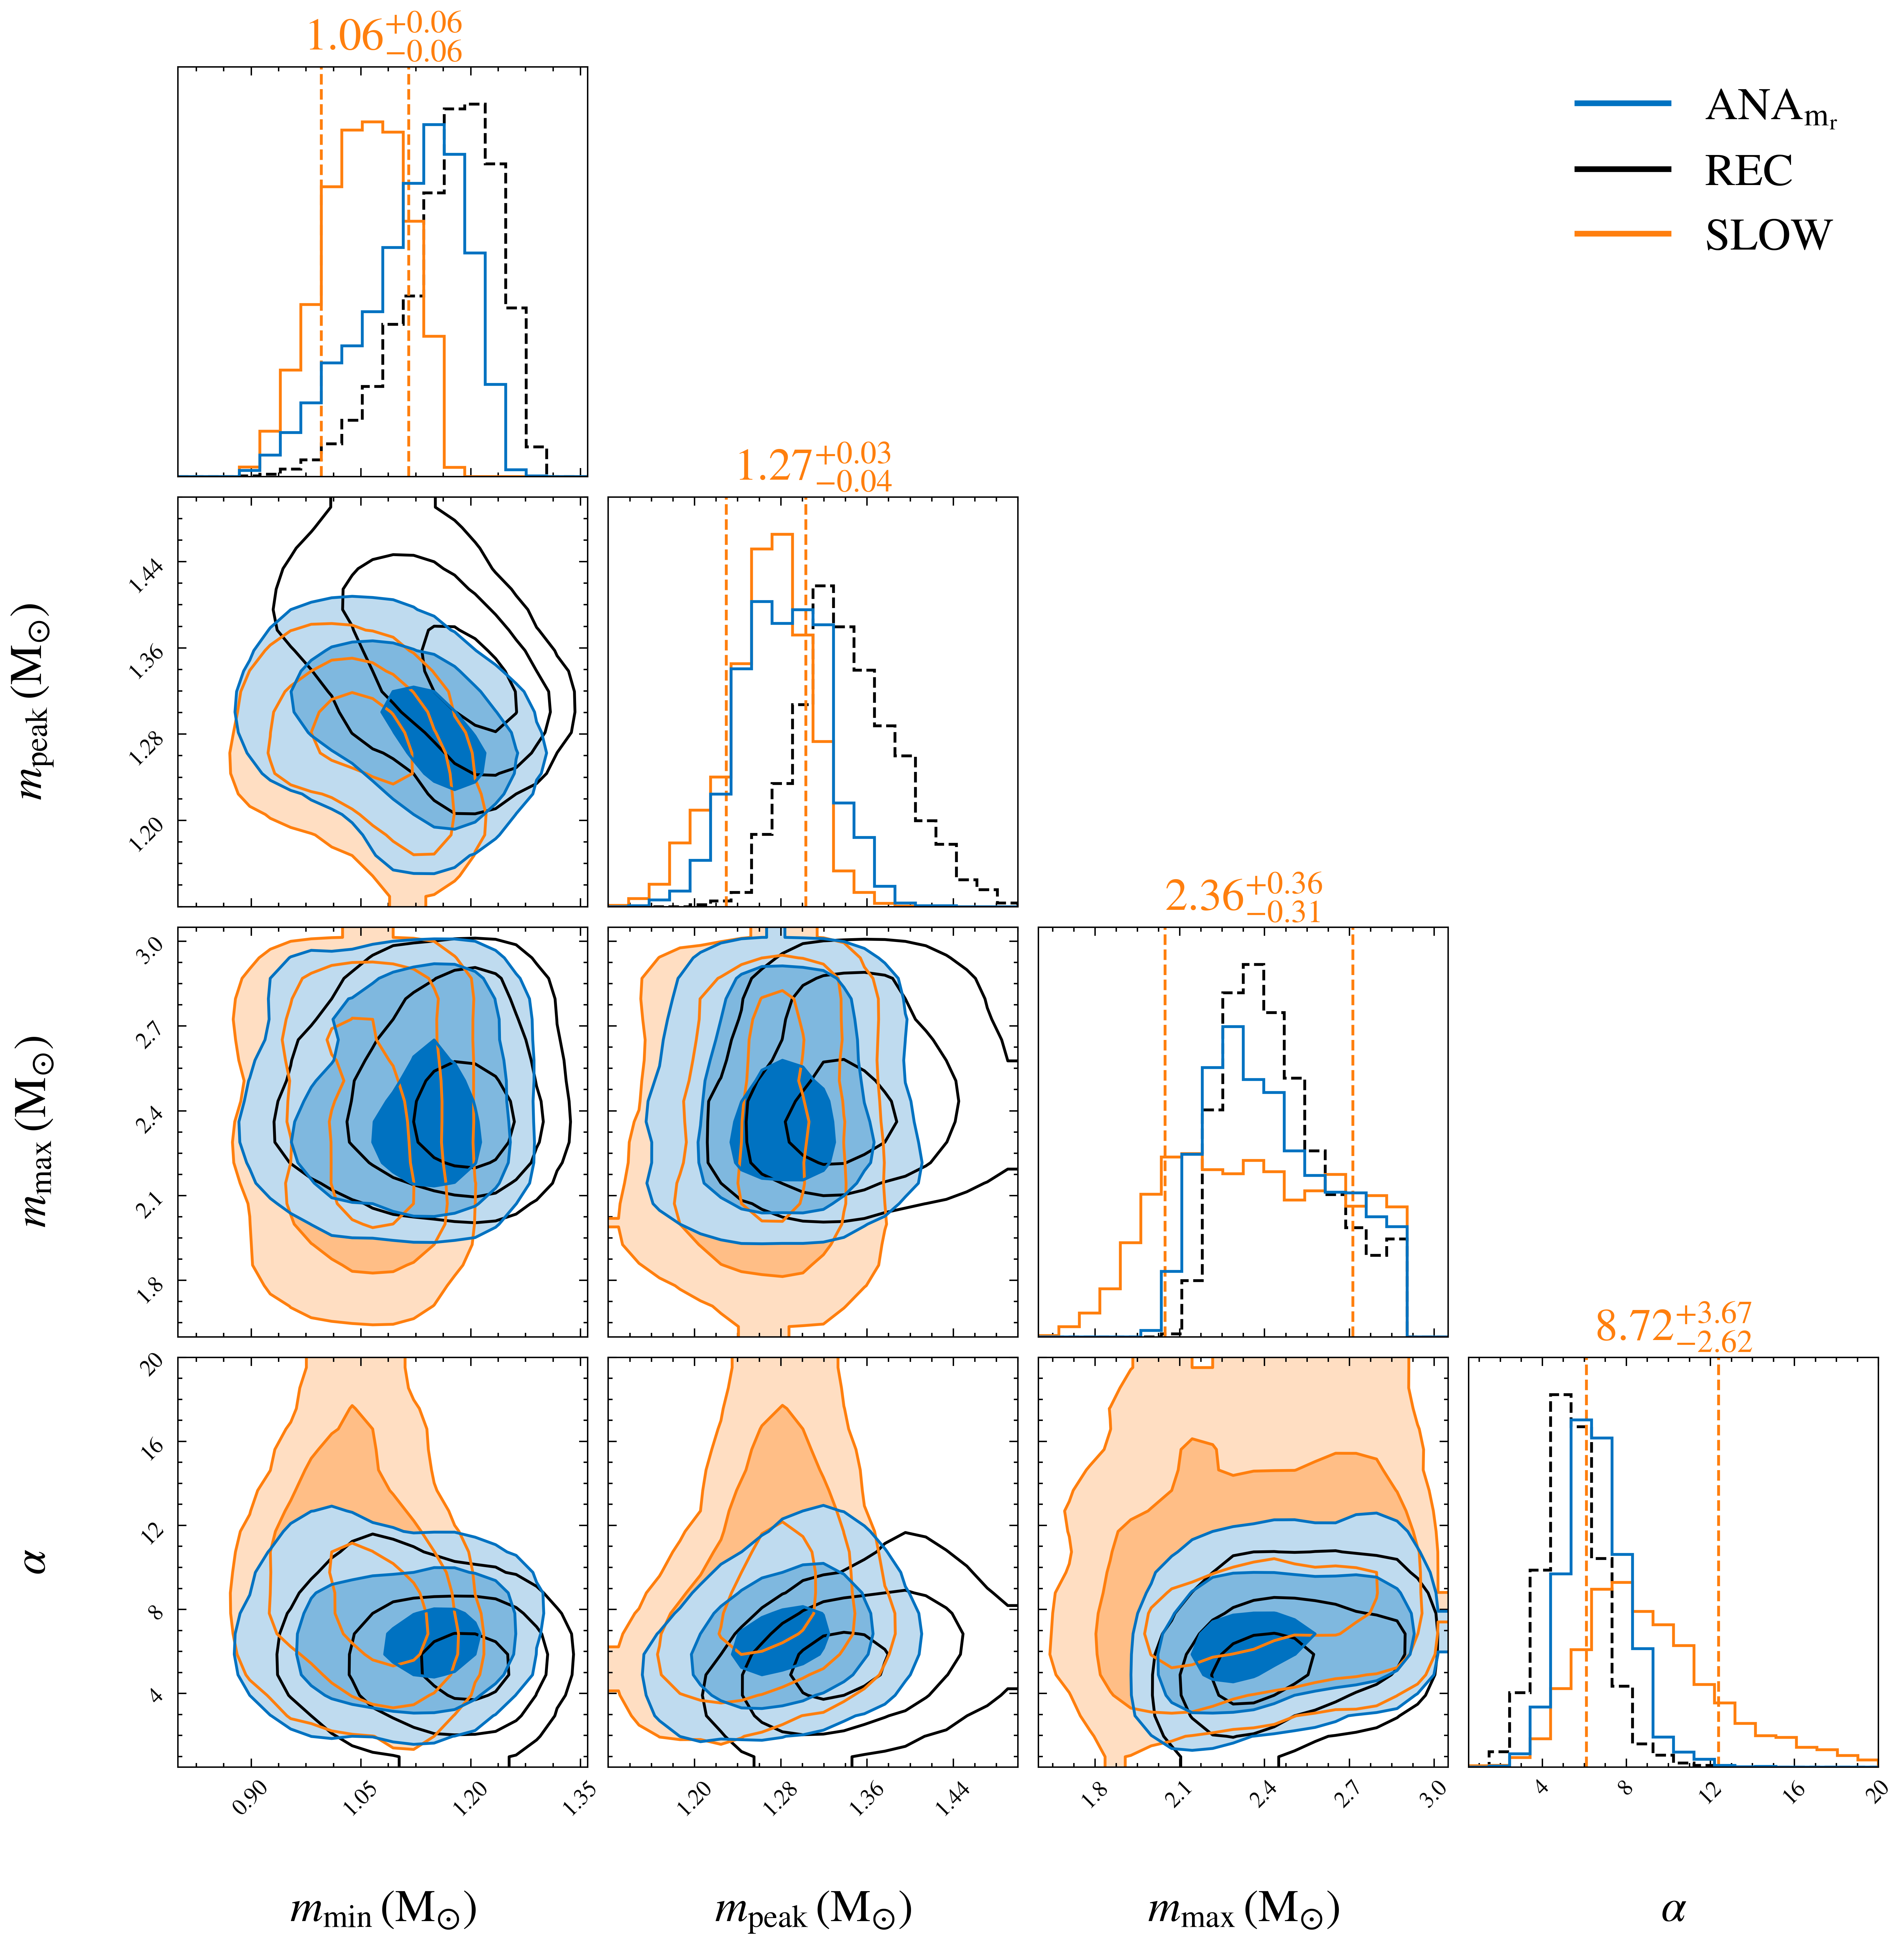

In [8]:
import corner.corner
import scienceplots
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

max_leni=max(len(anamr_pos_sam),len(mr_pos_sam) )
max_len =max(max_leni,len(ms_pos_sam))
ranges=([0.8,1.36],[1.12,1.5],[1.6,3.05],[0.5,20])
#################################
#################################
colors=['#ff7f0e','#0072c1']
torf=[True,False]
show_ti=[1,0]
labels_i=[None, [r'$m_{\rm{min}}\,({\rm {M_{\odot}}} )  $',r'$ m_{\rm{\rm peak}} \,({\rm {M_{\odot}}} ) $',r'$ m_{\rm{\rm max}} \,({\rm {M_{\odot}}} ) $',r'$\alpha$']]
quans=[[0.16, 0.84],[ ]]
label_fs=16
title_fs=16

fig= corner.corner(mr_pos_sam[:,[1,4,2,0]], #most one you want show
                       bins=20,smooth=0.9,color='k', 
                       weights=get_normalisation_weight(len(mr_pos_sam), max_len),
                       #labels=[r'$m_{\rm{min}}\,({\rm {M_{\odot}}} ) $',r'$ \delta_m \,({\rm {M_{\odot}}} ) $',
                       #        r'$\alpha$',r'$m_{\rm{max}} \,({\rm {M_{\odot}}} ) $' ],
                       #quantiles=[0.16, 0.84],
                       hist_kwargs=dict(ls='--'),
                       hist2d_kwargs=dict(ls='--'),
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       plot_density=False, plot_datapoints=False, fill_contours=False,
                       label_kwargs=dict(fontsize=label_fs),range=ranges,
                       show_titles=0,title_kwargs={"fontsize": title_fs,"color":'k'}
                  )
for i in range(2):
    fig=corner.corner(data_ms_anamr[i],  #1st dataset is the most different dataset, 2nd is the data similar to most data
                      fig=fig,
                       bins=20,smooth=0.9,color=colors[i],
                       weights=get_normalisation_weight(len(data_ms_anamr[i]), max_len),
                       labels=labels_i[i],
                       quantiles=quans[i],
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       plot_density=torf[i], plot_datapoints=False, fill_contours=True,
                       label_kwargs=dict(fontsize=label_fs),range=ranges,
                       hist_kwargs=dict(ls='-'),
                       show_titles=show_ti[i], title_kwargs={"fontsize": title_fs,"color":colors[i]}
                     )

k_line= mlines.Line2D([],[],color='k', lw=2,label=r'$\rm{REC}$')
orange_line= mlines.Line2D([],[],color='#ff7f0e',lw=2,label=r'$\rm{SLOW}$')
blue_line = mlines.Line2D([],[],color='#0072c1', lw=2,label=r'$\rm{ANA_{m_r}}$')#'#0072c1' blue

plt.legend(handles=[blue_line,k_line,orange_line],bbox_to_anchor=(1,4.2),loc='upper right',fontsize=label_fs)#prop={'size': 8})

plt.savefig(parent_dir_path+'/figures/extend_fig6_up.jpg')
plt.show()

# figure extended 6 down

In [9]:
i=0
mii=np.linspace(0.7,3,400)
post_data_model_top={}
for j in [1,7]:
    os.path.exists(main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[j],sub_model_name_list[i]) )
    fnames= glob.glob( main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[j],sub_model_name_list[i])  )
    fname=fnames[0]
    re=bilby.result.read_in_result( fname )
    temp_post=((re.posterior).iloc[:,0:-2]).values 
    post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]=temp_post
    
    peak_te=np.zeros(len(post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]) ) 
    for k in range(len(post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])])):
        post_tem=post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]
        mass_model=eval('utilizes_plot.hyper_prior_{}'.format(sub_model_name_list[i]) )
        model_curve_yi=mass_model(mii,post_tem[k,0],post_tem[k,1],post_tem[k,2],post_tem[k,3])
        peak_te[k]=HDI(mii,model_curve_yi,0.9)[1] 
    post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]=np.insert(post_tem,4,peak_te,axis=1)

In [10]:
post_data_model_top

{'post_ana_corrected_mrms_87_turn_on_pow': array([[10.5176569 ,  1.01108621,  1.9974154 ,  0.60432373,  1.28248248],
        [ 5.39287136,  0.93676511,  2.37332265,  0.76077533,  1.37457457],
        [ 7.54000448,  0.95137259,  2.36543751,  0.95421562,  1.36766767],
        ...,
        [ 6.15495378,  1.11237628,  2.2646449 ,  0.18684004,  1.25715716],
        [ 6.09690446,  1.12100536,  2.26757011,  0.16246564,  1.24794795],
        [ 5.92109181,  1.12021467,  2.24936989,  0.16616261,  1.24794795]]),
 'post_ana_radio_turn_on_pow': array([[21.89915713,  1.00896705,  2.21742165,  0.88099356,  1.23643644],
        [ 5.57325702,  0.980017  ,  2.1969893 ,  0.38076789,  1.24794795],
        [21.26812138,  1.047284  ,  1.93701089,  0.6938585 ,  1.25255255],
        ...,
        [10.60723128,  1.10484403,  2.11478999,  0.27141211,  1.28248248],
        [11.0056562 ,  1.10399218,  2.10330163,  0.27856343,  1.28248248],
        [10.52428278,  1.10850232,  2.04945899,  0.26368668,  1.28248248]])

In [11]:
ana_pos_sam=post_data_model_top["post_"+str(mrms_data_label[1])+'_'+str(sub_model_name_list[0])]
ana_radio_pos_sam=post_data_model_top["post_"+str(mrms_data_label[7])+'_'+str(sub_model_name_list[0])]

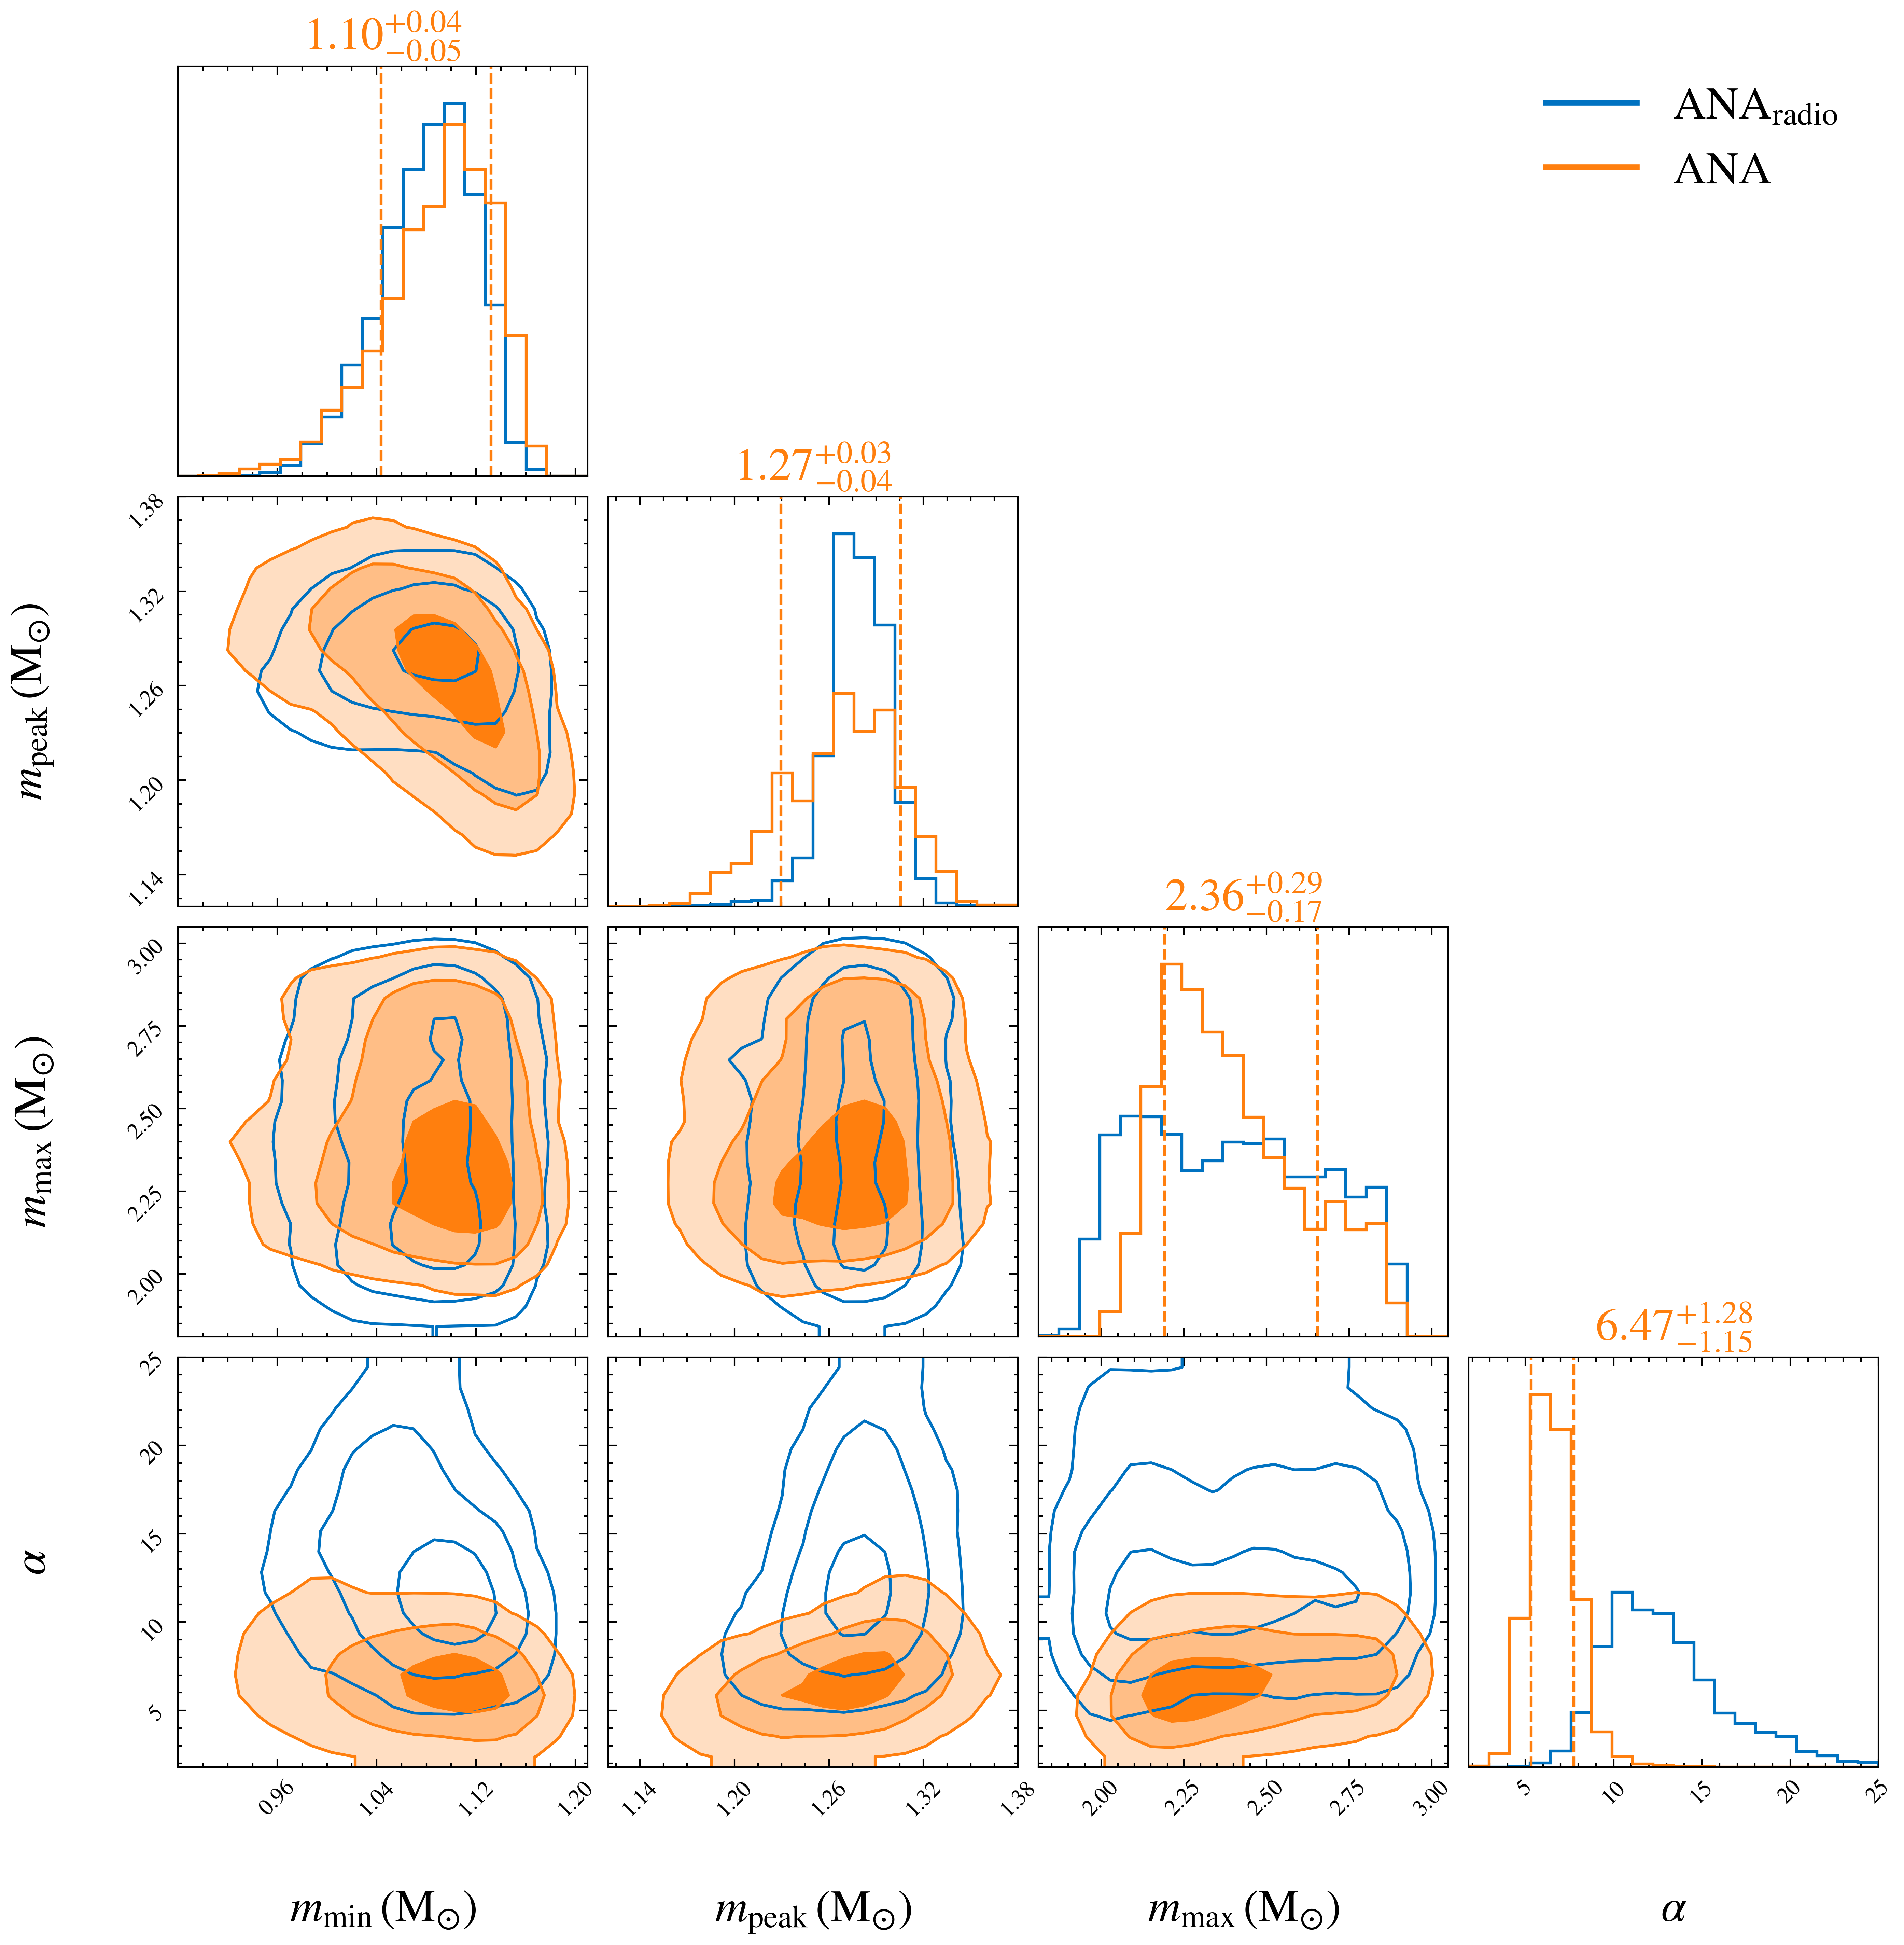

In [12]:
max_len=max(len(ana_pos_sam),len( ana_radio_pos_sam) )

ranges=([0.88,1.21],[1.12,1.38],[1.81,3.05],[1.8,25])
#################################
#################################
colors=['#ff7f0e','#0072c1']
torf=[True,False]
show_ti=[1,0]
labels_i=[None, [r'$m_{\rm{min}}\,({\rm {M_{\odot}}} )  $',r'$ m_{\rm{\rm peak}} \,({\rm {M_{\odot}}} ) $',r'$ m_{\rm{\rm max}} \,({\rm {M_{\odot}}} ) $',r'$\alpha$']]
quans=[[0.16, 0.84],[ ]]
label_fs=16
title_fs=16


fig= corner.corner(ana_radio_pos_sam[:,[1,4,2,0]], #most one you want show
                       bins=20,smooth=0.9,color=colors[1], 
                       weights=get_normalisation_weight(len(ana_radio_pos_sam), max_len),
                       labels=[r'$m_{\rm{min}}\,({\rm {M_{\odot}}} )  $',r'$ m_{\rm{\rm peak}} \,({\rm {M_{\odot}}} ) $',r'$ m_{\rm{\rm max}} \,({\rm {M_{\odot}}} ) $',r'$\alpha$'],
                       #quantiles=[0.16, 0.84],
                       #hist_kwargs=dict(ls='--'),
                       #hist2d_kwargs=dict(ls='--'),
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       plot_density=False, plot_datapoints=False, fill_contours=False,
                       label_kwargs=dict(fontsize=label_fs),range=ranges,
                       #show_titles=0,title_kwargs={"fontsize": title_fs,"color":'k'}
                  )

corner.corner(ana_pos_sam[:,[1,4,2,0]],  #1st dataset is the most different dataset, 2nd is the data similar to most data
                      fig=fig,
                       bins=20,smooth=0.9,color=colors[0],
                       weights=get_normalisation_weight(len(ana_pos_sam), max_len),
                       #labels=[r'$m_{\rm{min}}\,({\rm {M_{\odot}}} ) $',r'$ \delta_m \,({\rm {M_{\odot}}} ) $',
                       #        r'$\alpha$',r'$m_{\rm{max}} \,({\rm {M_{\odot}}} ) $' ],
                       quantiles=quans[0],
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       plot_density=1, plot_datapoints=False, fill_contours=True,
                       #label_kwargs=dict(fontsize=label_fs),
                       range=ranges,
                       hist_kwargs=dict(ls='-'),
                       show_titles=True, 
                      title_kwargs={"fontsize": title_fs,"color":colors[0]}
                     )

#k_line= mlines.Line2D([],[],color='k', lw=2,label=r'$\rm{PHE}$')
orange_line= mlines.Line2D([],[],color='#ff7f0e',lw=2,label=r'$\rm{ANA}$')
blue_line = mlines.Line2D([],[],color='#0072c1', lw=2,label=r'$\rm{ANA_{radio}}$')#'#0072c1' blue

plt.legend(handles=[blue_line,orange_line],bbox_to_anchor=(1,4.2),loc='upper right',fontsize=label_fs)#prop={'size': 8})

plt.savefig(parent_dir_path+'/figures/extended_fig6_down.jpg')
plt.show()
